In [104]:
import pandas as pd
from sklearn.utils import shuffle
from deicode.utils import build_block_model
from deicode.preprocessing import rclr
from deicode.optspace import OptSpace
import seaborn as sns
import pandas as pd
import numpy as np
from skbio.stats.composition import clr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib import ticker
plt.style.use('ggplot')
sns.set_style('whitegrid')
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20

def plot_pcoa(samples, md, ax, factor_, colors_map=['#1f78b4','#e31a1c']):
    """ 
    Parameters
    ----------
    samples : pd.DataFrame
        Contains PCoA coordinates
    md : pd.Dataframe
        Metadata object
    ax : matplotlib.Axes
        Contains matplotlib axes object
    """
    classes=np.sort(list(set(md[factor_].values)))
    cmap_out={}
    for sub_class,color_ in zip(classes,colors_map):
        idx = md[factor_] == sub_class        
        ax.scatter(samples.loc[idx, 0],
           samples.loc[idx, 1], 
           label=sub_class,
           facecolors=color_,
           edgecolors=color_,
           alpha=.8,linewidth=3)        
        cmap_out[sub_class]=color_
    ax.grid()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel('PC1',fontsize=15)
    ax.set_ylabel('PC2',fontsize=15)
    
    return ax


class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

%matplotlib inline

Here as a negative control we will compare RPCA output from a clear block model of rank 2 (positive control) and a negative control of random counts with the same mean seq. depth.

In [112]:

depth=2.5e3
overlap_=20
rank_=2
#run model with fit variables and new variants
_,X_signal=build_block_model(rank_,  depth/40, depth/40, 
                             depth, depth
                             ,200,1000,overlap=overlap_
                             ,mapping_on=False)
X_signal=pd.DataFrame(X_signal,
                      index=['OTU_'+str(x)
                                for x in range(X_signal.shape[0])],
                      columns=['sample_'+str(x) 
                               for x in range(X_signal.shape[1])])

#run model with fit variables and new variants
X_random=np.random.randint(0,np.mean(X_signal.values)*2.3,(1000,200))
X_random=pd.DataFrame(X_random,
                      index=['OTU_'+str(x)
                                for x in range(X_random.shape[0])],
                      columns=['sample_'+str(x) 
                               for x in range(X_random.shape[1])])
X_random.index = shuffle(X_random).index
X_random.columns = shuffle(X_random.T).index
X_random=X_random.T
X_random.sort_index(inplace=True)
X_random=X_random.T
X_random.sort_index(inplace=True)


#meta on cluster
meta = np.array(['Group 1']*int(X_signal.shape[1]/2)+['Group 2']*int(X_signal.shape[1]/2)).T
meta = pd.DataFrame(meta,index=X_signal.columns,columns=['group'])

print('X_random mean %.2f seq/sample'%X_random.sum(axis=0).mean())
print('X_signal mean %.2f seq/sample'%X_signal.sum(axis=0).mean())


X_random mean 4006.82 seq/sample
X_signal mean 4115.97 seq/sample


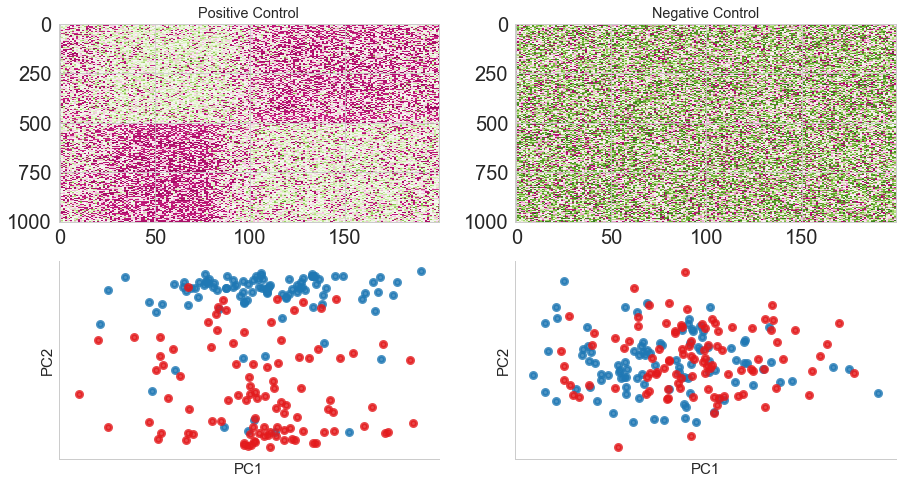

In [113]:
#RPCA on random
X_random_rclr = rclr().fit_transform(X_random.T)
U_random,s,V = OptSpace().fit_transform(X_random_rclr)
U_random = pd.DataFrame(U_random,index=X_random.columns)
#RPCA on very clear signal
X_signal_rclr = rclr().fit_transform(X_signal.T)
U_signal,s,V = OptSpace().fit_transform(X_signal_rclr)
U_signal = pd.DataFrame(U_signal,index=X_random.columns)

#show the results
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(15,8))

ax1.imshow(clr(X_signal+1),aspect='auto',norm=MidpointNormalize(midpoint=0.), cmap='PiYG')
ax1.set_title('Positive Control')
ax2.imshow(clr(X_random+1),aspect='auto',norm=MidpointNormalize(midpoint=0.), cmap='PiYG')
ax2.set_title('Negative Control')
_ = plot_pcoa(U_signal, meta, ax3, 'group')
_ = plot_pcoa(U_random, meta, ax4, 'group')

plt.show()
